# Kerchunk Useful Recipes with NASA Earthdata

#### *Author: Dean Henze, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary

This notebook goes through several functionalities of kerchunk, specifically using it with NASA Earthdata and utilizing the `earthaccess` package. It is meant to be a quick-start reference that introduces some key capabilities / characteristics of the package. This notebook does not go into depth on what kerchunk is, so the unfamiliar user is encouraged to check out some of the references below. In short, kerchunk is a Python package which allows you to generate "reference files", which one can think of as road maps for the computer to more rapidly and efficiently navigate through the arrays in a large data set. Once a reference file for a data set is created and stored in an accessible location, it allows us e.g. to lazy load data faster, access subsets of the data quicker (either spatially, temporally, or any other dimension in the data set), and in some cases perform computations faster.

The functionalities of kerchunk covered in this notebook are:
1. Generating a reference file in JSON format for the first year of the MUR 0.01 degree resolution sea surface temperature data set.
2. Generating a reference file in PARQUET format for the first year of the MUR 0.01 degree resolution sea surface temperature data set.
3. Adding an extra day of the MUR record to our existing reference file.
4. Using the reference file to perform a basic analysis on the MUR data set with a parallel computing cluster.

## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook

* Earthdata login account: An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account.

* Compute environment: This notebook is meant to be run in the cloud (AWS instance running in us-west-2), recommended on a VM with at minimum

* VM type: ...


#### Prerequisite knowledge


#### Learning Outcomes

## Import Packages and Other Setup
```
pip install git+https://github.com/fsspec/kerchunk
pip install fastparquet xarray earthaccess coild fsspec
```

In [1]:
import os
import fsspec
import kerchunk
from kerchunk.df import refs_to_dataframe
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import ujson
import json
import xarray as xr
import earthaccess
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled
import matplotlib.pyplot as plt

In [2]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Generating a reference file in JSON format for one year of MUR 0.01 degree SST

### 1.1 Locate Data File S3 endpoints in Earthdata Cloud 
The first step is to find the S3 endpoints to the files and generate file-like objects to use with kerchunk. Handling access credentials to Earthdata and then finding the endpoints can be done a number of ways (e.g. using the `requests`, `s3fs` packages) but we choose to use the `earthaccess` package for its convenience and brevity. We will get two years of MUR files, from beginning 2019 to end 2020. 

In [3]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [4]:
# Get AWS creds
fs = earthaccess.get_s3fs_session(daac="PODAAC")

In [5]:
granule_info = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    temporal=("2019-01-01", "2020-12-31"),
    )

In [6]:
# Generate's the file-like objects from the files located in the previous code block:
fobjs = earthaccess.open(granule_info)

QUEUEING TASKS | :   0%|          | 0/732 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/732 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/732 [00:00<?, ?it/s]

In [7]:
# Endpoints found in this attribute:
example_endpoint = fobjs[0].full_name
example_endpoint

's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

### 1.2 Generate kerchunk reference files for each MUR file in year 2019
It is necessary to create reference files for each data file individually before they can be combined into a single reference file for the entire record. The time for generating many of these individual files can add up, so this section also covers the option to use parallel computing.

First, define a small wrapper function around kerchunk and earthaccess packages.

In [16]:
def single_ref_earthaccess(fobj, dir_save=None):
    """
    Create a reference for a single data file. "fobj" (earthaccess.store.EarthAccessFile 
    object) is the output from earthaccess.open(), which also has the file endpoint. 
    Option to save as a JSON to direcotry "dir_save", with file name of the corresponding 
    data file with ".json" appended. Otherwise reference info is returned.
    """
    endpoint = fobj.full_name
    reference = SingleHdf5ToZarr(fobj, endpoint, inline_threshold=0).translate()
    
    if dir_save is not None:
        with open(dir_save + endpoint.split('/')[-1]+'.json', 'w') as outf:
            outf.write(ujson.dumps(reference))
    else:
        return reference, endpoint # returns both the kerchunk reference and the path the file on podaac-ops-cumulus-protected

Which can immediately be used to create a reference file and open one of the MUR files with Xarray, at which point it can be used just as if we had opened the MUR netCDF file directly:

In [9]:
%%time
# Create reference file:
reference, endpoint = single_ref_earthaccess(fobjs[0])

CPU times: user 367 ms, sys: 121 ms, total: 488 ms
Wall time: 3.51 s


In [10]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def opendf_withref(ref, fs_data):
    """
    "ref" is a kerchunk reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
        )
    return data

In [20]:
%%time
data = opendf_withref(reference, fs)
print(data)

<xarray.Dataset> Size: 23GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 8B 2019-01-01T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 5GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 3GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 5GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (47)
CPU times: user 179 ms, sys: 24.8 ms, total: 204 ms
Wall time: 554 ms


**For us, reference file creation took ~4 seconds, so processing a year would take *4 x 365 ~ 24 minutes***. One could easily write a simple for-loop to accomplish this, e.g.

```
for fobj in fobjs[:365]:
    single_ref_earthaccess(fobj, dir_save=<directory of your choice>)
```

However, we speed things up using basic parallel computing. 

### 1.2.1 Parallelize using Dask local cluster
If using the suggested `m6i.8xlarge` AWS EC2 instance, there are 32 CPUs available and each should have enough memory that we can utilize all 32 at once. If working on a different VM-type, change the `n_workers` in the call to `Client()` below as needed.

In [11]:
## Save reference JSONs in this directory:
dir_refs_indv_2019 = './reference_jsons_individual_2019/'
!mkdir $dir_refs_indv_2019

mkdir: cannot create directory ‘./reference_jsons_individual_2019/’: File exists


In [19]:
# Check how many cpu's are on this VM:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [13]:
# Start up cluster:
client = Client(n_workers=32, threads_per_worker=1)

In [17]:
# Setup parallel computations:
single_ref_earthaccess_par = delayed(single_ref_earthaccess)
tasks = [single_ref_earthaccess_par(fo, dir_save=dir_refs_indv_2019) for fo in fobjs[:365]]

In [18]:
%%time
# Run parallel computations:
results = da.compute(*tasks)

CPU times: user 9.66 s, sys: 2.58 s, total: 12.2 s
Wall time: 1min


### 1.2.2 Optional Alternative: Parallelize using distributed cluster with Coiled
At PO.DAAC we have been testing the third party software/package Coiled which makes it easy to spin up distributed computing clusters in the cloud. Since we suspect that Coiled may become a key member of the Cloud ecosystem for earth science researchers, this optional section is included, which can be used as an alternative to Section 1.2.1 for generating the reference files in parallel.

In [11]:
## Save reference JSONs in this directory:
dir_refs_indv_2019 = './reference_jsons_individual_2019/'
!mkdir $dir_refs_indv_2019

mkdir: cannot create directory ‘./reference_jsons_individual_2019/’: File exists


In [ ]:
%%time

## --------------------------------------------
## Create single reference files with parallel computing using Coiled
## --------------------------------------------

# Wrap `create_single_ref` into coiled function:
single_ref_earthaccess_par = coiled.function(
    region="us-west-2", spot_policy="on-demand", 
    vm_type="m6i.large", n_workers=16
    )(single_ref_earthaccess)

# Begin computations:
results = single_ref_earthaccess_par.map(fobjs[:365])

# Save results to JSONs as they become available:
for reference, endpoint in results:
    name_ref = dir_refs_indv_2019 + endpoint.split('/')[-1].replace('.nc', '.json')
    with open(name_ref, 'w') as outf:
        outf.write(ujson.dumps(reference))

In [ ]:
single_ref_earthaccess_par.cluster.shutdown()

### 1.3 Create combined reference file and use it to open the data
However the single reference files were generated in the previous section, they can now be used to create a single reference file for the entire year 2019. The computation time for this step can also be decreased with parallel computing, but in this case serial computing is used.

In [22]:
%%time

## --------------------------------------------
## Create combined reference file
## --------------------------------------------

ref_files_indv = [dir_refs_indv_2019+f for f in os.listdir(dir_refs_indv_2019) if f.endswith('.json')]
ref_files_indv.sort()

## Combined reference file
kwargs_mzz = {'remote_protocol':"s3", 'remote_options':fs.storage_options, 'concat_dims':["time"]}
mzz = MultiZarrToZarr(ref_files_indv, **kwargs_mzz)
ref_combined = mzz.translate()

 # Save reference info to JSON:
with open("ref_combined_2019.json", 'wb') as outf:
    outf.write(ujson.dumps(ref_combined).encode())

CPU times: user 1.32 s, sys: 217 ms, total: 1.54 s
Wall time: 12.9 s


In [21]:
%%time
# Open the portion of the MUR record corresponding to the reference file created:
data = opendf_withref(json.load(open("ref_combined_2019.json")), fs)
print(data)

<xarray.Dataset> Size: 1TB
Dimensions:           (time: 50, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 400B 2019-01-01T09:00:00 ... 2019...
Data variables:
    analysed_sst      (time, lat, lon) float64 259GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 259GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 259GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    mask              (time, lat, lon) float32 130GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 259GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (47)
CPU times: user 768 ms, sys: 85.4 ms, total: 853 ms
Wall time: 1.1 s


The data will open quickly now that we have the reference file. Compare that to an attempt at opening these same files with `Xarray` the "traditional" way with a call to `xr.open_mfdataset()`. On a smaller machine, the following line of code will either fail or take a long (possibly very long) amount of time:

In [ ]:
## You can try un-commenting and running this but your notebook will probably crash:
# data = xr.open_mfdataset(fobjs[:365])

## 2. Generate the same MUR reference file but in PARQUET format

For larger datasets, the combined reference file in JSON format can become large. For example, if we wanted to create a reference JSON for the entire MUR 0.01 degree record it is estimated to be 1-2 GB, and the MUR data set isn't even *that* large in the scheme of things. One solution to this is to save the reference information in PARQUET format (demonstrated in this section) which reduces the disk space required.

Instead of re-creating all individual reference files, this section will load the combined 2019 reference file, then re-save in parquet format and use it to open the MUR data.

In [ ]:
ref_combined_2019 = json.load(open("ref_combined_2019.json"))

In [ ]:
%%time
# Save reference info to parquet:
refs_to_dataframe(ref_combined_2019, "ref_combined_2019.parq")

In [ ]:
%%time
data = opendf_withref("ref_combined_2019.parq", fs)
print(data)

In [ ]:
## Compare size of JSON vs parquet, printed in MB
    # JSON
print("JSON:", os.path.getsize("ref_combined_2019.json")/10**6, "MB")
    # parquet
size_parq = 0 
for path, dirs, files in os.walk("ref_combined_2019.parq"):
    for f in files:
        fp = os.path.join(path, f)
        size_parq += os.path.getsize(fp)
print("PARQUET:", size_parq/10**6, "MB")

## 3. Combining reference files
This section demonstrates that reference files can be combined in two examples:

1. A single reference file (for the first day of 2020) is appended to the combined reference file for 2019 generated in the previous section.
2. A second year-long combined reference file is created for all of 2020 and combined with the 2019 reference file.

In both cases, a key result is that creating the final product (e.g. combining two reference files) is much shorter than it would have been to create it from scratch.

### 3.1 Adding an extra day of the MUR record to our existing reference file.

In [ ]:
%%time
# Create reference file for first day in 2020:
ref_add, endpoint_add = single_ref_earthaccess(fobjs[365])

name_ref_add = endpoint_add.split('/')[-1].replace('.nc', '.json')
with open(name_ref_add, 'w') as outf:
    outf.write(ujson.dumps(ref_add))

In [ ]:
%%time

# Add it to the combined reference file:
kwargs_mzz = {'remote_protocol':"s3", 'remote_options':fs.storage_options, 'concat_dims':["time"]}
mzz = MultiZarrToZarr(["ref_combined_2019.json", name_ref_add], **kwargs_mzz)
ref_combined_add1day = mzz.translate()

 # Save reference info to JSON:
with open("ref_combined_add1day.json", 'wb') as outf:
    outf.write(ujson.dumps(ref_combined_add1day).encode())

**Appending an additional file does not take much time!**

In [ ]:
%%time
# Open data using new reference file:
data = opendf_withref("ref_combined_add1day.json", fs)
print(len(data["time"]))
print(data)

### 3.2 Combining two year-long combined reference files
Individual files for 2020 are created and combined into a single reference file, then this file is combined with the 2019 reference file. As before, parallel computing is used to speed up creation of the files, but this could also be accomplished with a for-loop. 

In [22]:
## Save individual reference JSONs in this directory:
dir_refs_indv_2020 = './reference_jsons_individual_2020/'
!mkdir $dir_refs_indv_2020

In [13]:
## !!!!!!!!!!!
## This line only needs to be run if you don't have a cluster already running
## from Section 1.2.1
## !!!!!!!!!!!
# Start up cluster:
client = Client(n_workers=32, threads_per_worker=1)

In [23]:
# Setup parallel computations:
single_ref_earthaccess_par = delayed(single_ref_earthaccess)
tasks = [single_ref_earthaccess_par(fo, dir_save=dir_refs_indv_2020) for fo in fobjs[365:]]

In [24]:
%%time
# Run parallel computations:
results = da.compute(*tasks)

CPU times: user 12 s, sys: 3.02 s, total: 15 s
Wall time: 1min 17s


In [ ]:
%%time

## --------------------------------------------
## Create combined reference file for 2020
## --------------------------------------------

ref_files_indv = [dir_refs_indv_2020+f for f in os.listdir(dir_refs_indv_2020) if f.endswith('.json')]
ref_files_indv.sort()

## Combined reference file
kwargs_mzz = {'remote_protocol':"s3", 'remote_options':fs.storage_options, 'concat_dims':["time"]}
mzz = MultiZarrToZarr(ref_files_indv, **kwargs_mzz)
ref_combined = mzz.translate()

 # Save reference info to JSON:
with open("ref_combined_2020.json", 'wb') as outf:
    outf.write(ujson.dumps(ref_combined).encode())

In [ ]:
%%time

## --------------------------------------------
## Then create combined reference file for 2019 and 2020
## --------------------------------------------

kwargs_mzz = {'remote_protocol':"s3", 'remote_options':fs.storage_options, 'concat_dims':["time"]}
mzz = MultiZarrToZarr(["ref_combined_2019.json", "ref_combined_2020.json"], **kwargs_mzz)
ref_combined_2years = mzz.translate()

 # Save reference info to JSON:
with open("ref_combined_2019-2020.json", 'wb') as outf:
    outf.write(ujson.dumps(ref_combined_2years).encode())

***Note the large difference in computation time to create the 2020 combined reference file from the individual reference files, vs. combining the two year-long reference files for 2019 and 2020. The latter is much shorter!***

In [ ]:
%%time
# Open data using new reference file:
data = opendf_withref("ref_combined_2019-2020.json", fs)
print(len(data["time"]))
print(data)

## 4. Using a reference file to analyze the MUR data with a parallel computing.

In [28]:
def seasonal_cycle_regional(data_array, lat_region, lon_region):
    ## Subset to region:
    da_regional = data_array.sel(lat=slice(*lat_region), lon=slice(*lon_region))
    
    ## Remove any linear trends:
    p = da_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
    fit = xr.polyval(da_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
    da_detrend = (da_regional - fit) # xarray is smart enough to subtract along the time dim only.
    
    ## Mean seasonal cycle:
    seasonal_cycle = da_detrend.groupby("time.month").mean("time")
    return seasonal_cycle

In [24]:
# Region to perform analysis over:
lat_region = (30, 45)
lon_region = (-135, -105)

### 4.1 Using a local cluster

In [25]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [26]:
## Local Dask Cluster
client = Client(n_workers=16, threads_per_worker=1)
print(client.cluster)
client.dashboard_link

/opt/coiled/env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43811 instead
  warnings.warn(


LocalCluster(da665823, 'tcp://127.0.0.1:37015', workers=16, threads=16, memory=122.31 GiB)


'https://cluster-bvkzc.dask.host/jupyter/proxy/43811/status'

2024-10-28 15:59:40,427 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a5aea08baf2b2b7c4f82fd16997e35ad initialized by task ('rechunk-merge-rechunk-transfer-0af25ef7d25e4c9d5f13bbe26bb3614b', 0, 25, 6, 12, 37, 9) executed on worker tcp://127.0.0.1:38245
2024-10-28 15:59:40,445 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 33cc5d8c465e5644e9a531c7ab1f5280 initialized by task ('rechunk-merge-rechunk-transfer-0af25ef7d25e4c9d5f13bbe26bb3614b', 0, 24, 5, 12, 36, 8) executed on worker tcp://127.0.0.1:33799
2024-10-28 15:59:40,453 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 2f05770ddf1410aed0066c6bbfe59f88 initialized by task ('rechunk-merge-rechunk-transfer-0af25ef7d25e4c9d5f13bbe26bb3614b', 0, 23, 6, 12, 35, 9) executed on worker tcp://127.0.0.1:38245
2024-10-28 15:59:40,513 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 50a58f5b04b9e1e0314f07b1b10878ea initialized by task ('rechunk-merge-rechunk-transfer-0af25ef7d25e4c9d5f13bbe26bb36

In [27]:
data = opendf_withref("ref_combined_2019.parq", fs)
sst = data['analysed_sst']
sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
sst

<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)> Size: 2TB
dask.array<rechunk-p2p, shape=(365, 17999, 36000), dtype=float64, chunksize=(200, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon      (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 3kB 2019-01-01T09:00:00 ... 2019-12-31T09:...
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRR19_G-NAVO, AV...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [29]:
%%time
seasonal_cycle = seasonal_cycle_regional(sst, lat_region, lon_region).compute()

/opt/coiled/env/lib/python3.12/site-packages/dask/array/core.py:4894: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


Text(0, 0.5, '$\\Delta$T (K)')

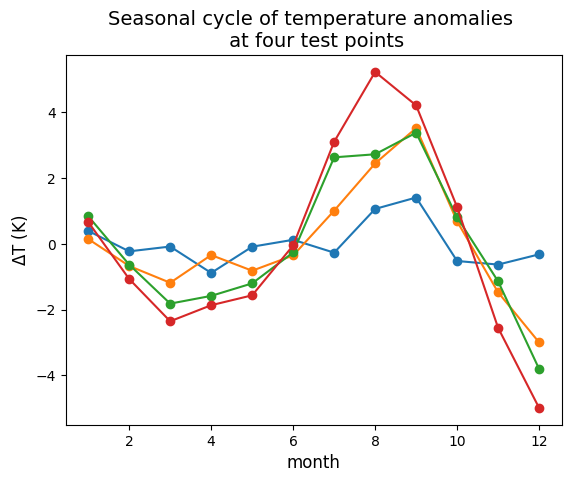

In [30]:
## Test plot seasonal cycle at a few gridpoint locations

# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

fig = plt.figure()
ax = plt.axes()

for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    ax.plot(scycle_point['month'], scycle_point.values, 'o-')

ax.set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
ax.set_xlabel("month", fontsize=12)
ax.set_ylabel(r"$\Delta$T (K)", fontsize=12)

### 4.2 Using a distributed cluster
We use the third party software/package Coiled to spin up our distributed cluster.

In [31]:
cluster = coiled.Cluster(
    n_workers=25, 
    region="us-west-2", 
    worker_vm_types="c7g.large", # or can try "m7a.medium"
    scheduler_vm_types="c7g.large", # or can try "m7a.medium"
    ) 
client = cluster.get_client()

Output()

╭──────────────────────────────── Package Info ────────────────────────────────╮
│                ╷                                                             │
│   Package      │ Note                                                        │
│ ╶──────────────┼───────────────────────────────────────────────────────────╴ │
│   virtualizarr │ Wheel built from                                            │
│                │ /opt/coiled/env/.path-deps/virtualizarr-1.0.1.dev22+g7d47   │
│                │ dcc-py3-none-any.whl                                        │
│                ╵                                                             │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

In [ ]:
## Bottle neck that we can't open the data using the parquet file then use on a distributed cluster!!! 
## E.g. loading the data the following way, then using our "seasonal_cycle_regional()" fxn will not work: 

# data = opendf_withref("ref_combined_2019.parq", fs)
# sst = data['analysed_sst']
# sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
# sst

In [32]:
%%time

##==================================================================
## Only works from file if the JSON is loaded into memory first!!!!
##==================================================================
with open("ref_combined_2019.json") as f:
    ref_loaded = json.load(f)
data = opendf_withref(ref_loaded, fs)
sst = data['analysed_sst']
sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
sst

CPU times: user 7.24 s, sys: 1.26 s, total: 8.5 s
Wall time: 8.32 s


<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)> Size: 2TB
dask.array<rechunk-p2p, shape=(365, 17999, 36000), dtype=float64, chunksize=(200, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon      (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 3kB 2019-01-01T09:00:00 ... 2019-12-31T09:...
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRR19_G-NAVO, AV...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [33]:
%%time
seasonal_cycle = seasonal_cycle_regional(sst, lat_region, lon_region).compute()

/opt/coiled/env/lib/python3.12/site-packages/dask/array/core.py:4894: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 71.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 9.53 s, sys: 2.68 s, total: 12.2 s
Wall time: 54.3 s


In [ ]:
client.shutdown()

Text(0, 0.5, '$\\Delta$T (K)')

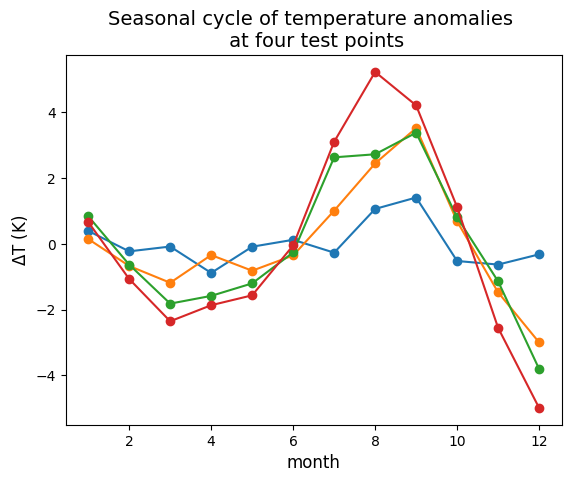

In [34]:
## Test plot seasonal cycle at a few gridpoint locations

# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

fig = plt.figure()
ax = plt.axes()

for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    ax.plot(scycle_point['month'], scycle_point.values, 'o-')

ax.set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
ax.set_xlabel("month", fontsize=12)
ax.set_ylabel(r"$\Delta$T (K)", fontsize=12)